In [50]:
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers
from tensorflow import keras
import datetime as dt


In [7]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [8]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))

Found 3670 images belonging to 5 classes.


In [9]:
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 256, 256, 3)
Labe batch shape:  (32, 5)


In [12]:
classifier_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/2" #@param {type:"string"}

In [14]:
def classifier(x):
  classifier_module = hub.Module(classifier_url)
  return classifier_module(x)
  
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(classifier_url))

In [19]:
classifier_layer = layers.Lambda(classifier, input_shape = IMAGE_SIZE+[3])
classifier_model = tf.keras.Sequential([classifier_layer,
                                       tf.keras.layers.Dense(32, activation=tf.nn.relu),
                                        tf.keras.layers.Dense(10, activation=tf.nn.softmax)])
classifier_model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0427 16:46:03.078609 4636775872 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                32064     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 32,394
Trainable params: 32,394
Non-trainable params: 0
_________________________________________________________________


In [20]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


In [21]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

65536/61306 [================================] - 0s 0us/step


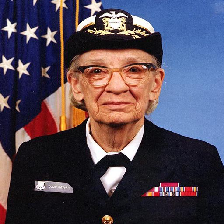

In [23]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SIZE)
grace_hopper 

In [24]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [25]:
result = classifier_model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 10)

In [26]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

7

In [27]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


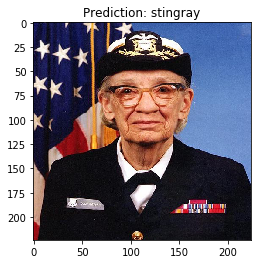

In [28]:
plt.imshow(grace_hopper)
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name)

In [29]:
result_batch = classifier_model.predict(image_batch)
labels_batch = imagenet_labels[np.argmax(result_batch, axis=-1)]
labels_batch

array(['stingray', 'stingray', 'goldfish', 'stingray', 'hen', 'goldfish',
       'stingray', 'cock', 'stingray', 'cock', 'stingray', 'stingray',
       'stingray', 'great white shark', 'great white shark', 'stingray',
       'stingray', 'goldfish', 'goldfish', 'stingray', 'stingray',
       'stingray', 'stingray', 'stingray', 'stingray', 'hammerhead',
       'stingray', 'stingray', 'cock', 'goldfish', 'goldfish', 'cock'],
      dtype='<U30')

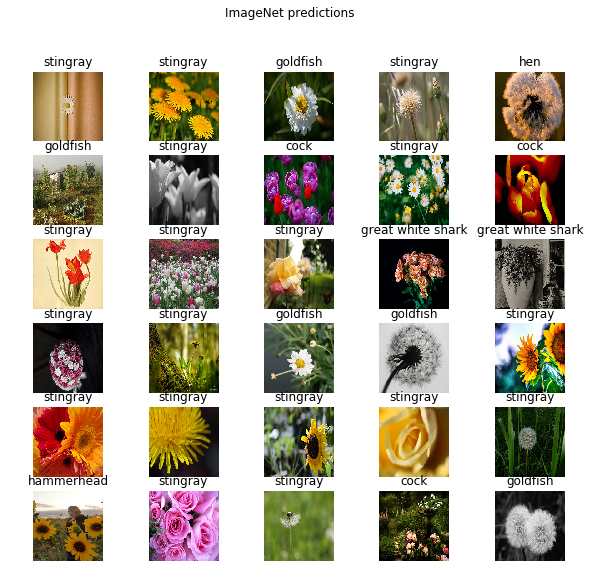

In [30]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [31]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2" #@param {type:"string"}
def feature_extractor(x):
  feature_extractor_module = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

In [32]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


In [33]:
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])
features_extractor_layer.trainable = False
model = tf.keras.Sequential([
  features_extractor_layer,
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0427 17:13:36.558750 4636775872 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 165,258
Trainable params: 165,258
Non-trainable params: 0
_________________________________________________________________


In [34]:
init = tf.global_variables_initializer()
sess.run(init)

In [35]:
result = model.predict(image_batch)
result.shape

(32, 10)

In [37]:
model.compile(
  optimizer=tf.train.AdamOptimizer(), 
  loss='categorical_crossentropy',
  metrics=['mae','accuracy'])

In [38]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])

In [1]:
steps_per_epoch=tf.ceil(len(feature_extractor_url)/255.0)
steps_per_epoch
model.fit(ds, epochs=1, steps_per_epoch=1)

NameError: name 'tf' is not defined

In [46]:

label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names



array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

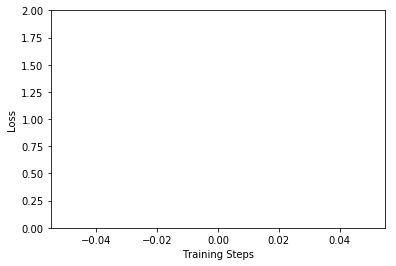

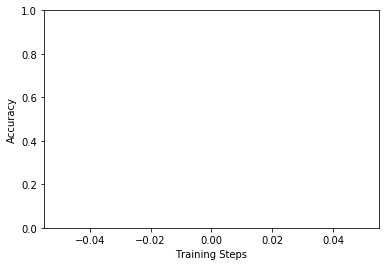

In [51]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)